In [2]:
import pandas as pd
from sqlite3 import connect

In [3]:
conn = connect('testDB.sqlite3')

# Анализ продаж

## Логика и последовательность выполнения

Сначала, я выгрузил данные по планам продаж и выручке и их фактическим значением "Бухгалтерии.Контур" из базы данных в pandas датафрейм. Далее, посчитал абсолютное и относительное отклонение. На основе этих данных построил погодовой и помесячный план-факт график.

После этого, я перешел к анализу тарифов. Выгрузил по ним данные и сгруппировал по названию (Лайт, Базовый,...) и сроку подписки. По данным построил графики динамики продаж и выручки конкретных тарифов, а так же круговые диаграммы распределения продаж по тарифам за каждый год, чтобы посмотреть на возможное изменение спроса клиентов.

Далее, посмотрел соотношения новых и старых клиентов в течении лет, чтобы проверить успешность привлечения новой аудитории. Посмотрел, на выбор тарифа новых клиентов.

Заметив ранее, что в 2018 продажи упали после роста в предыдущих годах, поискал в интернете внешнеэкономические причины, которые могли бы повлиять на это. Так же, проверил общую тенденцию продаж по всем продуктам Контура и провер гипотезу о переходе клиентов с "Бухгалтерии.Контур" на другой аналогичный продукт контура.

В конце, решил посмотреть на структуру клиентов "Бухгалтерии.Контур": посмотрел на оборот и количество сотрудников компаний, использующих данный продукт и проверил есть ли зависимисть между выбором тарифа и этими показателями. Так же, посмотрел по этим данным размер бизнесов, покупающих "Бухгалтерию" и соответствие этого целевой аудитории продукта. 

In [3]:
plan = pd.read_sql('''
select strftime('%Y', dt) as year, strftime('%m', dt) as month,sum(plan_amount) as plan_amount, sum(plan_count) as plan_count from rPlan
where product = 'Бухгалтерия.Контур'
group by year, month
''',conn)

In [4]:
fact = pd.read_sql('''
select strftime('%Y', BDate) as year, strftime('%m', BDate) as month, sum(Cost) as fact_amount, count(*) as fact_count from BillsContent
join Bills using(bID)
join PriceItems using (piID)
where product = 'Бухгалтерия.Контур'
group by year, month
''',conn)

In [5]:
plan_year = pd.read_sql('''
select strftime('%Y', dt) as year, sum(plan_amount) as plan_amount, sum(plan_count) as plan_count from rPlan
where product = 'Бухгалтерия.Контур'
group by year
''',conn)
fact_year = pd.read_sql('''
select strftime('%Y', BDate) as year, sum(Cost) as fact_amount, count(*) as fact_count from BillsContent
join Bills using(bID)
join PriceItems using (piID)
where product = 'Бухгалтерия.Контур'
group by year
''',conn)
plan_fact_year = plan_year.merge(fact_year,on=['year'], )
plan_fact_year['amount_abs'] = plan_fact_year['fact_amount'] - plan_fact_year['plan_amount']
plan_fact_year['amount_rel'] = plan_fact_year['amount_abs'] / plan_fact_year['plan_amount'] * 100
plan_fact_year['count_abs'] = plan_fact_year['fact_count'] - plan_fact_year['plan_count']
plan_fact_year['count_rel'] = plan_fact_year['count_abs'] / plan_fact_year['plan_count'] * 100
plan_fact_year['year'] = plan_fact_year['year'].astype(int)
plan_fact_year

,year,plan_amount,plan_count,fact_amount,fact_count,amount_abs,amount_rel,count_abs,count_rel
0,2015,95156955.3,6754,109637370.0,8117,14480414.7,15.217400,1363,20.180634
1,2016,212981151.6,15048,227408480.0,16554,14427328.4,6.773993,1506,10.007974
2,2017,221839125.7,15143,233107030.0,16488,11267904.3,5.079313,1345,8.881992
3,2018,184790652.6,11935,189199860.0,12823,4409207.4,2.386055,888,7.440302


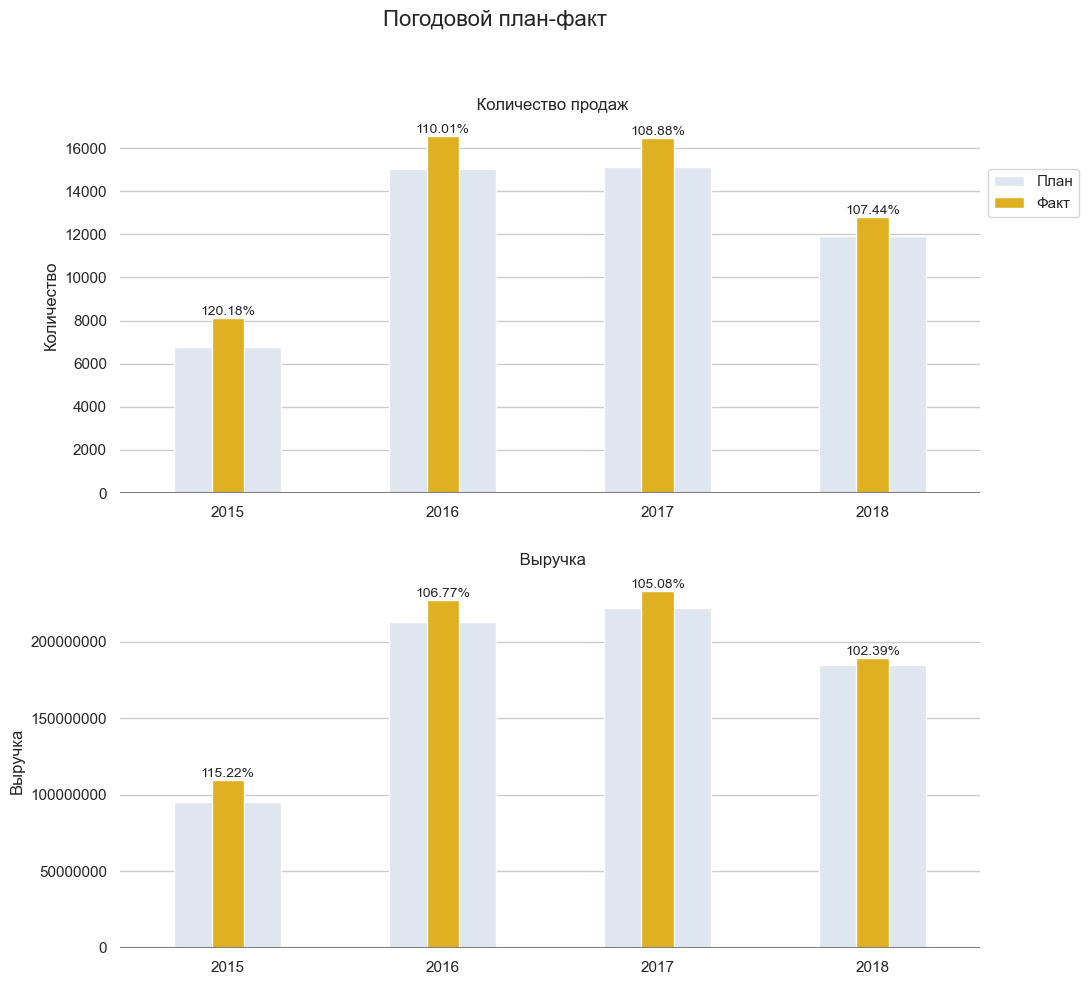

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

sns.set_theme(style="whitegrid")

fig = plt.figure()
fig.suptitle("Погодовой план-факт\n", fontsize=16)
fig.set_size_inches(10,10)
plt.rcParams['font.size'] = 10

plt.subplot(2,1,1)

sns.barplot(x=plan_fact_year['year'],y=plan_fact_year['plan_count'],label="План",width= 0.5,color= '#dce6f2')
ax = sns.barplot(x=plan_fact_year['year'],y=plan_fact_year['fact_count'], label='Факт', width=0.15,color='#ffc001')
for i in ax.containers[1:]:
    ax.bar_label(i,plan_fact_year['count_rel'].apply(lambda x: "{:.2f}%".format(100 + x)))
plt.title(f'\n\n Количество продаж')
plt.ylabel("Количество")
plt.xlabel('')
plt.box(False)
plt.axhline(y=0, color='gray')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.ticklabel_format(axis='y', style='plain')

plt.subplot(2,1,2)

sns.barplot(x=plan_fact_year['year'],y=plan_fact_year['plan_amount'],label="План",width= 0.5,color= '#dce6f2')
ax = sns.barplot(x=plan_fact_year['year'],y=plan_fact_year['fact_amount'], label='Факт', width=0.15,color='#ffc001')
for i in ax.containers[1:]:
    ax.bar_label(i,plan_fact_year['amount_rel'].apply(lambda x: "{:.2f}%".format(100 + x)))
plt.title(f'\n Выручка')
plt.ylabel("Выручка")
plt.xlabel('')
plt.box(False)
plt.axhline(y=0, color='gray')
plt.ticklabel_format(axis='y', style='plain')


plt.tight_layout()
plt.show()


In [8]:
plan_fact = plan.merge(fact,on=['year',''], )
plan_fact['amount_abs'] = plan_fact['fact_amount'] - plan_fact['plan_amount']
plan_fact['amount_rel'] = plan_fact['amount_abs'] / plan_fact['plan_amount'] * 100
plan_fact['count_abs'] = plan_fact['fact_count'] - plan_fact['plan_count']
plan_fact['count_rel'] = plan_fact['count_abs'] / plan_fact['plan_count'] * 100
plan_fact['year'] = plan_fact['year'].astype(int)
plan_fact[''] = plan_fact[''].astype(int)
plan_fact

,year,month,plan_amount,plan_count,fact_amount,fact_count,amount_abs,amount_rel,count_abs,count_rel
0,2015,6,6421425.9,421,17637780.0,1282,11216354.1,174.670771,861,204.513064
1,2015,7,16417996.9,1071,17148580.0,1263,730583.1,4.449892,192,17.927171
2,2015,8,14782956.5,1140,15043500.0,1109,260543.5,1.762459,-31,-2.719298
3,2015,9,14045566.8,1013,14354920.0,1063,309353.2,2.202497,50,4.935834
4,2015,10,14714617.9,1059,15243820.0,1130,529202.1,3.596438,71,6.704438
5,2015,11,14284107.8,989,14899010.0,1109,614902.2,4.304799,120,12.133468
6,2015,12,14490283.5,1061,15309760.0,1161,819476.5,5.655352,100,9.425071
7,2016,1,17792138.5,1226,23941370.0,1746,6149231.5,34.561509,520,42.414356
8,2016,2,19937160.0,1422,19360970.0,1411,-576190.0,-2.890030,-11,-0.773558
9,2016,3,19650704.4,1404,19768450.0,1432,117745.6,0.599193,28,1.994302


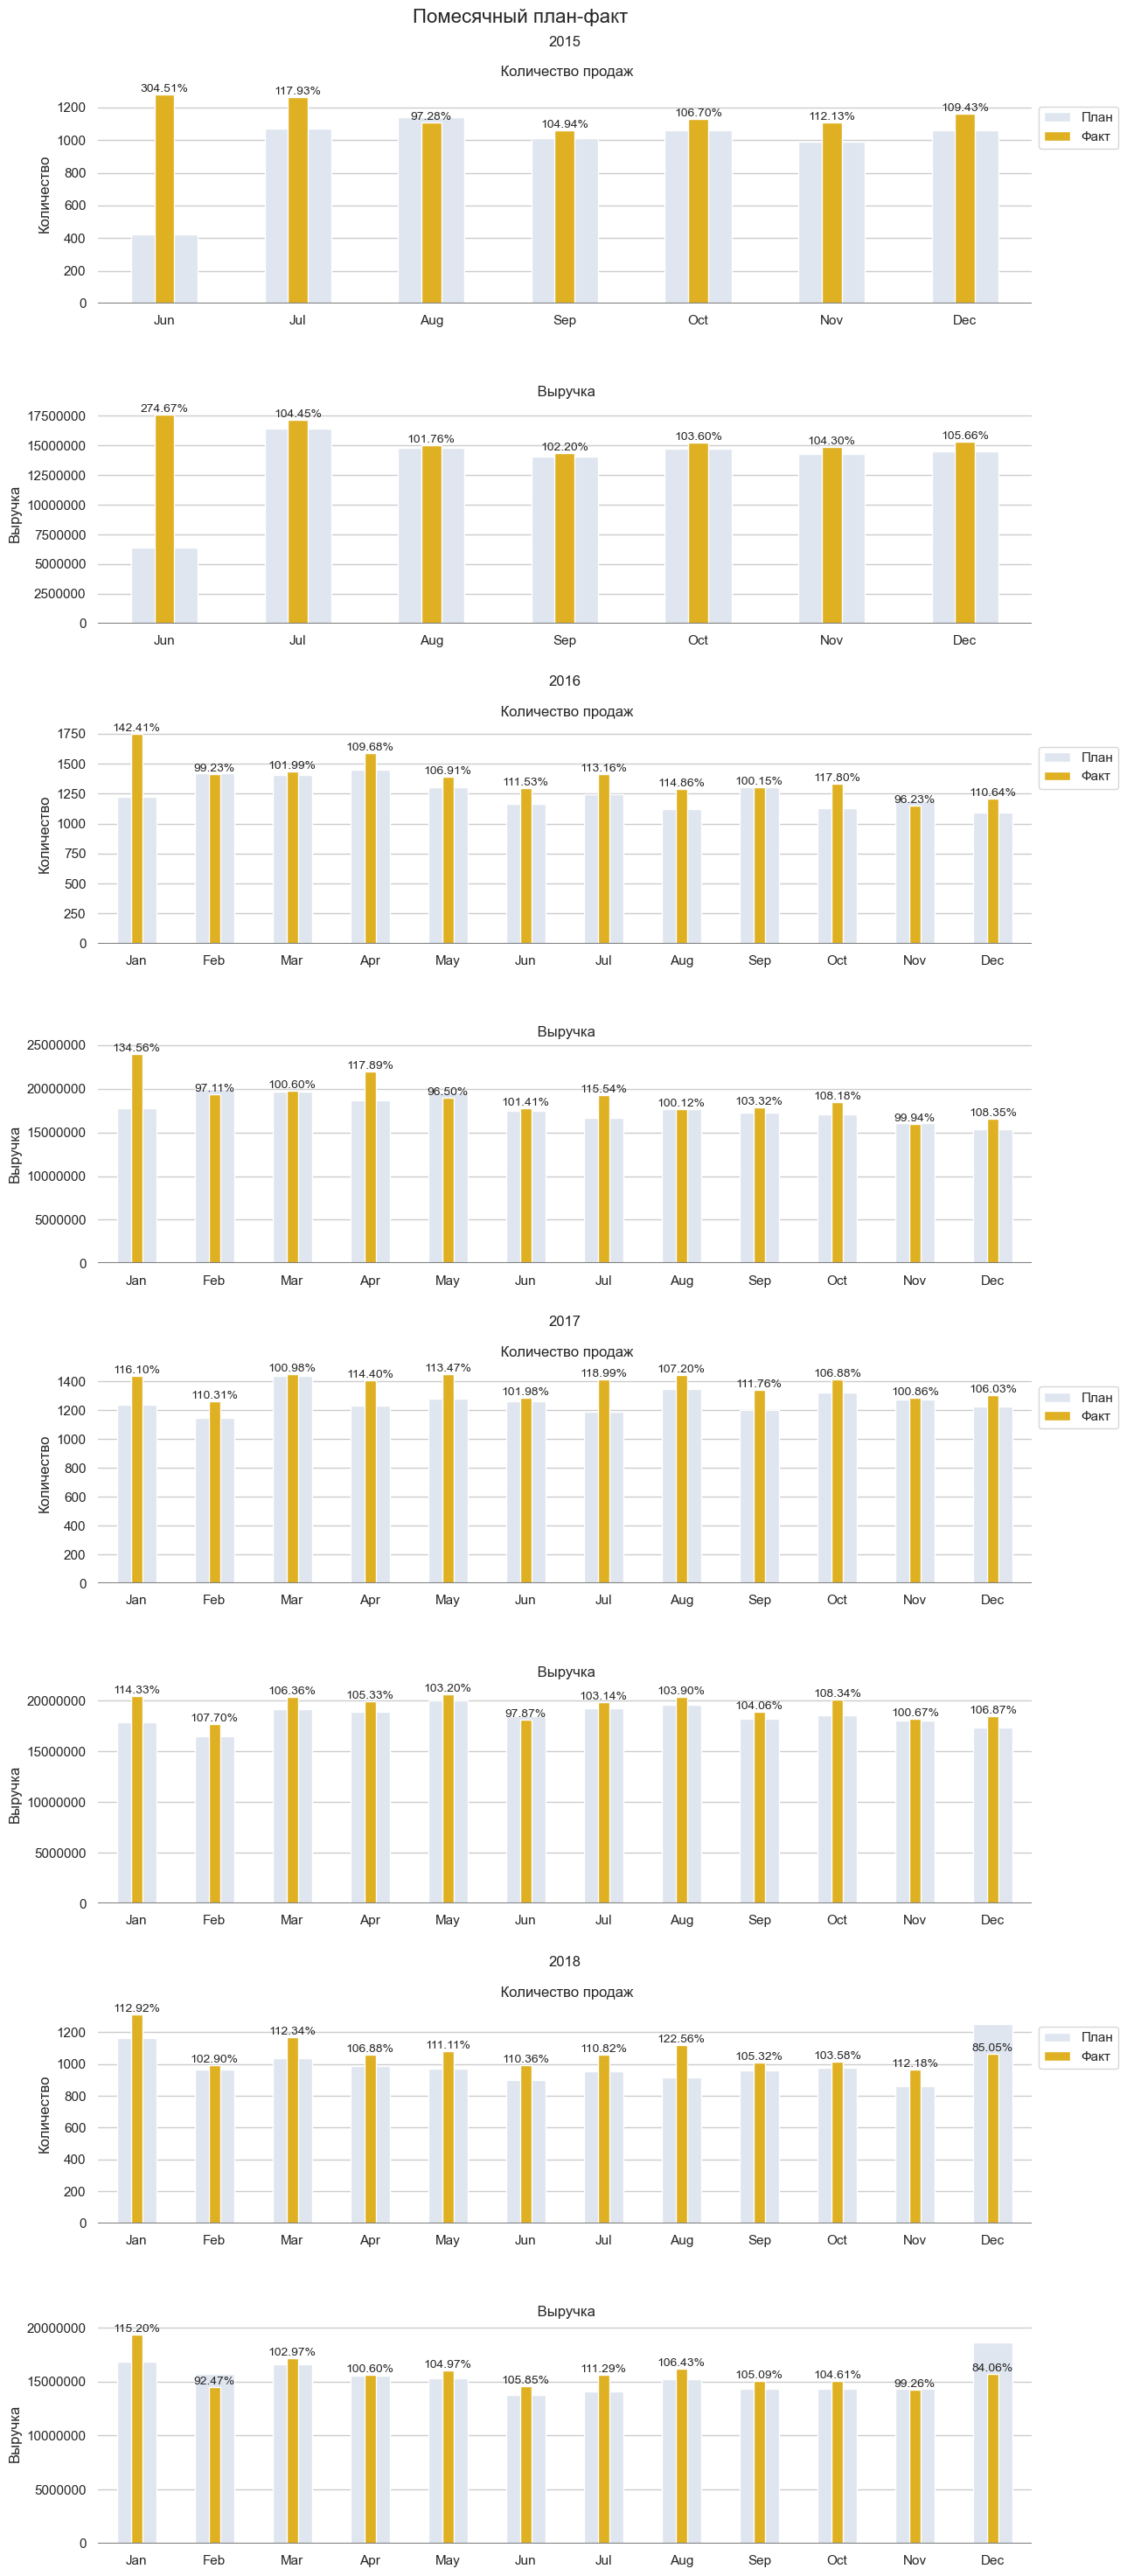

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

sns.set_theme(style="whitegrid")

years = plan_fact['year'].unique()
fig = plt.figure()
fig.suptitle("Помесячный план-факт\n", fontsize=16)
fig.set_size_inches(12,30)
plt.rcParams['font.size'] = 10

for index, year in enumerate(years):
    plt.subplot(8,1, 2 * index+1)
    plan_fact_subset = plan_fact[plan_fact['year'] == year].copy()
    plan_fact_subset['month_str'] = plan_fact_subset['month'].apply(lambda x: datetime.date(2000,x, 1).strftime("%b"))

    sns.barplot(x=plan_fact_subset['month_str'],y=plan_fact_subset['plan_count'],label="План",width= 0.5,color= '#dce6f2')
    ax = sns.barplot(x=plan_fact_subset['month_str'],y=plan_fact_subset['fact_count'], label='Факт', width=0.15,color='#ffc001')
    for i in ax.containers[1:]:
        ax.bar_label(i,plan_fact_subset['count_rel'].apply(lambda x: "{:.2f}%".format(100 + x)))
    plt.title(f'\n{year}\n\n Количество продаж')
    plt.ylabel("Количество")
    plt.xlabel('')
    plt.box(False)
    plt.axhline(y=0, color='gray')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    
    plt.subplot(8,1,2 * index + 2)
    sns.barplot(x=plan_fact_subset['month_str'],y=plan_fact_subset['plan_amount'],label="План",width= 0.5,color= '#dce6f2')
    ax = sns.barplot(x=plan_fact_subset['month_str'],y=plan_fact_subset['fact_amount'], label='Факт', width=0.15,color='#ffc001')
    for i in ax.containers[1:]:
        ax.bar_label(i,plan_fact_subset['amount_rel'].apply(lambda x: "{:.2f}%".format(100 + x)))
    plt.title(f'\n Выручка')
    plt.ylabel("Выручка")
    plt.xlabel('')
    plt.box(False)
    plt.axhline(y=0, color='gray')
    plt.ticklabel_format(axis='y', style='plain')


plt.tight_layout()
plt.show()


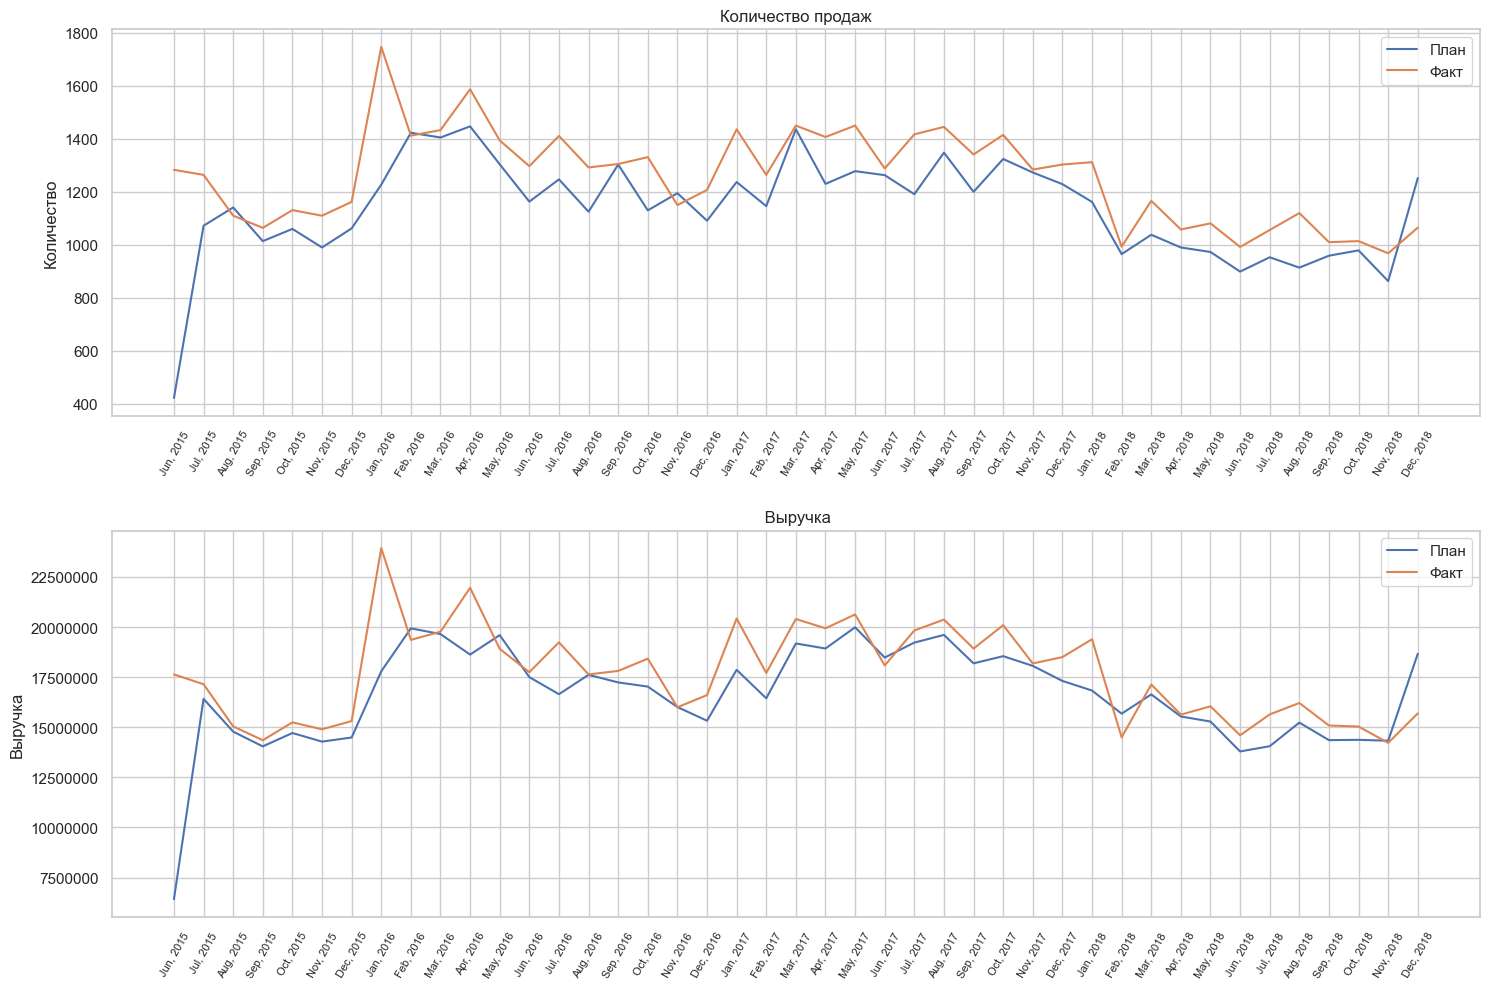

In [10]:
ticks = ["%s, %d" % (datetime.datetime(2000,int(row['month']),1).strftime("%b"), row['year']) for _, row in plan_fact.iterrows()]
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.lineplot(plan_fact['plan_count'],label='План')
sns.lineplot(plan_fact['fact_count'],label='Факт')
plt.title('Количество продаж')
plt.ylabel("Количество")
plt.xticks(range(len(ticks)),ticks,rotation=60,fontsize=8)
plt.subplot(2,1,2)
sns.lineplot(plan_fact['plan_amount'],label='План')
sns.lineplot(plan_fact['fact_amount'],label='Факт')
plt.title('\n Выручка')
plt.ylabel("Выручка")
plt.xticks(range(len(ticks)),ticks,rotation=60,fontsize=8)
plt.ticklabel_format(axis='y',style='plain')
plt.tight_layout()
plt.show()


In [137]:
plans = pd.read_sql('''
select piID as id, piName as Тарифы, strftime('%Y', BDate) as year, count(*) as Количество_продаж, min(Cost) as Мин_цена, max(Cost) as Макс_цена, avg(Cost) as Средняя_цена ,sum(Cost) as Общая_выручка
from PriceItems
join BillsContent using (piID)
join Bills using (bID)
where product = "Бухгалтерия.Контур"
group by piID, year
order by id
''',conn)
pd.set_option('display.max_colwidth', None)

In [138]:
pd.set_option('display.max_rows', None)

plans

,id,Тарифы,year,Количество_продаж,Мин_цена,Макс_цена,Средняя_цена,Общая_выручка
0,15,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. по тарифному плану ""Лайт""",2015,282,3980.0,4300.0,4143.120567,1168360.0
1,15,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. по тарифному плану ""Лайт""",2016,487,4000.0,4400.0,4208.213552,2049400.0
2,15,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. по тарифному плану ""Лайт""",2017,520,4030.0,4550.0,4290.250000,2230930.0
3,15,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. по тарифному плану ""Лайт""",2018,404,4100.0,4900.0,4491.089109,1814400.0
4,45,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. (Базовый)",2015,271,7960.0,8600.0,8275.867159,2242760.0
5,45,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. (Базовый)",2016,527,8000.0,8800.0,8395.066414,4424200.0
6,45,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. (Базовый)",2017,515,8060.0,9100.0,8589.592233,4423640.0
7,45,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. (Базовый)",2018,445,8190.0,9750.0,8928.808989,3973320.0
8,75,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. по тарифному плану ""Максимальный""",2015,280,11930.0,12850.0,12377.678571,3465750.0
9,75,"Доступ к сервису ""Бухгалтерия.Контур"" сроком на 6 мес. по тарифному плану ""Максимальный""",2016,566,11990.0,13150.0,12585.883392,7123610.0


In [20]:
plan_groups = {
    'Лайт': [15, 120,195, 240],
    'Базовый': [45, 136],
    'Максимальный': [75],
    'ТД': [105, 180, 225, 270],
}

plan_durations = {
    '1': [105],
    '2': [180],
    '3': [225],
    '4': [270],
    '6': [15, 45, 75],
    '12': [105,120,136],
    '18': [195],
    '24': [240],
}

def id_to_plan(id):
    for plan, ids in plan_groups.items():
        if id in ids:
            return plan
        
def id_to_dur(id):
    for dur, ids in plan_durations.items():
        if id in ids:
            return int(dur)

In [140]:
plans['Тариф'] = plans['id'].apply(lambda x: id_to_plan(x))
plans['Длительность'] = plans['id'].apply(lambda x: id_to_dur(x))
plans2 = plans.drop(columns=['Тарифы'])
plans2.sort_values(by=['Тариф', "Длительность"])

,id,year,Количество_продаж,Мин_цена,Макс_цена,Средняя_цена,Общая_выручка,Тариф,Длительность
4,45,2015,271,7960.0,8600.0,8275.867159,2242760.0,Базовый,6
5,45,2016,527,8000.0,8800.0,8395.066414,4424200.0,Базовый,6
6,45,2017,515,8060.0,9100.0,8589.592233,4423640.0,Базовый,6
7,45,2018,445,8190.0,9750.0,8928.808989,3973320.0,Базовый,6
20,136,2015,840,15910.0,17150.0,16536.642857,13890780.0,Базовый,12
21,136,2016,1631,15990.0,17550.0,16749.435929,27318330.0,Базовый,12
22,136,2017,1634,16120.0,18200.0,17170.501836,28056600.0,Базовый,12
23,136,2018,1309,16380.0,19500.0,17881.604278,23407020.0,Базовый,12
0,15,2015,282,3980.0,4300.0,4143.120567,1168360.0,Лайт,6
1,15,2016,487,4000.0,4400.0,4208.213552,2049400.0,Лайт,6


In [141]:
plans_grouped_by_plan = plans2.drop(columns=['Мин_цена',	'Макс_цена',	'Средняя_цена', "Длительность",'id'])
plans_grouped_by_plan = plans_grouped_by_plan.groupby(['year',"Тариф"]).sum()
plans_grouped_by_plan

Количество_продаж  Общая_выручка
year Тариф                                         
2015 Базовый                    1111     16133540.0
     Лайт                       6623     90038080.0
     Максимальный                280      3465750.0
     ТД                          103            0.0
2016 Базовый                    2158     31742530.0
     Лайт                      13642    188542340.0
     Максимальный                566      7123610.0
     ТД                          188            0.0
2017 Базовый                    2149     32480240.0
     Лайт                      13645    193361090.0
     Максимальный                563      7265700.0
     ТД                          131            0.0
2018 Базовый                    1754     27380340.0
     Лайт                      10581    156208330.0
     Максимальный                416      5611190.0
     ТД                           72            0.0

In [142]:
plans_grouped_by_dur = plans2.drop(columns=['Мин_цена',	'Макс_цена',	'Средняя_цена', "Тариф",'id'])
plans_grouped_by_dur = plans_grouped_by_dur.groupby(['year',"Длительность"]).sum()
plans_grouped_by_dur.reset_index(inplace=True)
plans_grouped_by_dur['Длительность'] = plans_grouped_by_dur['Длительность'].astype(str)
plans_grouped_by_dur

,year,Длительность,Количество_продаж,Общая_выручка
0,2015,1,48,0.0
1,2015,2,29,0.0
2,2015,3,13,0.0
3,2015,4,13,0.0
4,2015,6,833,6876870.0
5,2015,12,1547,19734020.0
6,2015,18,2438,30205900.0
7,2015,24,3196,52820580.0
8,2016,1,34,0.0
9,2016,2,64,0.0


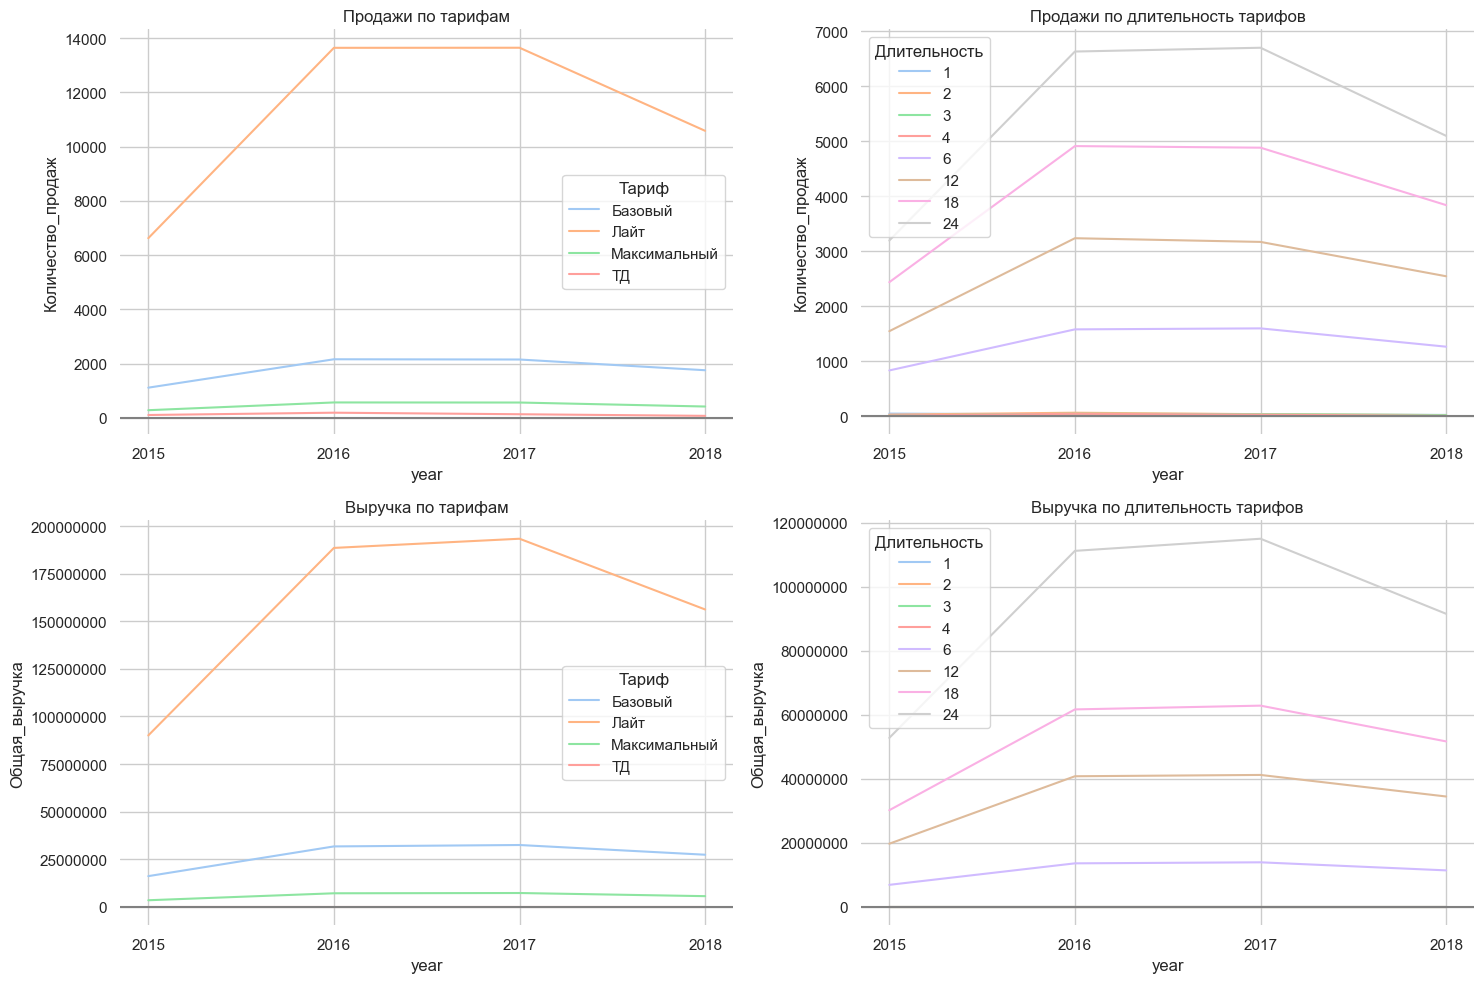

In [143]:
sns.set_theme(palette='pastel',style='whitegrid')

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
sns.lineplot(data = plans_grouped_by_plan,x='year',y='Количество_продаж', hue = 'Тариф')
plt.box(False)
plt.axhline(y=0, color='gray')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.title("Продажи по тарифам")

plt.subplot(2,2,3)
sns.lineplot(data = plans_grouped_by_plan,x='year',y='Общая_выручка', hue = 'Тариф')
plt.box(False)
plt.axhline(y=0, color='gray')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.ticklabel_format(axis='y',style='plain')
plt.title("Выручка по тарифам")

plt.subplot(2,2,2)
sns.lineplot(data = plans_grouped_by_dur,x='year',y='Количество_продаж', hue = 'Длительность')
plt.box(False)
plt.axhline(y=0, color='gray')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.title("Продажи по длительность тарифов")

plt.subplot(2,2,4)
sns.lineplot(data = plans_grouped_by_dur,x='year',y='Общая_выручка', hue = 'Длительность')
plt.box(False)
plt.axhline(y=0, color='gray')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.8))
plt.ticklabel_format(axis='y',style='plain')
plt.title("Выручка по длительность тарифов")


plt.tight_layout()
plt.show()

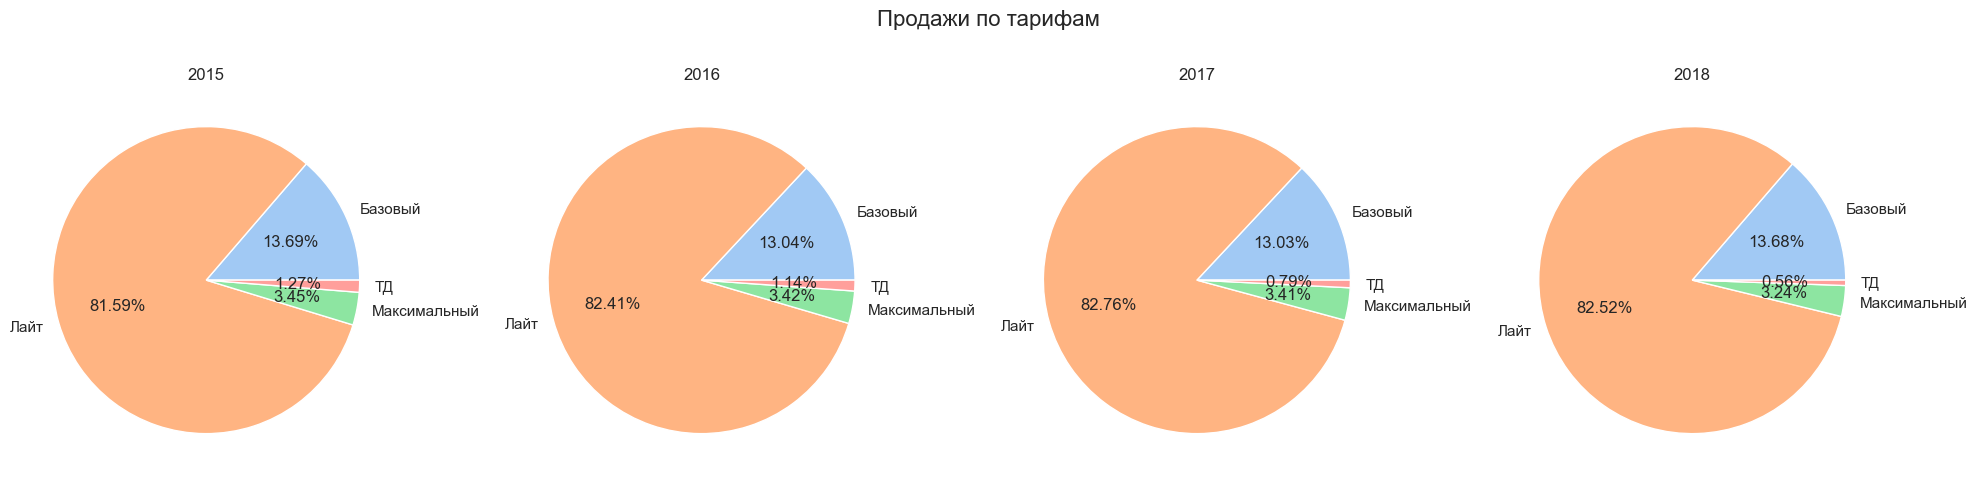

In [150]:
p = plans_grouped_by_plan.reset_index()

colors = sns.color_palette('pastel')

fig = plt.figure()
fig.suptitle("Продажи по тарифам\n", fontsize=16)
fig.set_size_inches(20,5)
for index, year in enumerate(p['year'].unique()):
    plt.subplot(1,4,index+1)
    pp = p[p['year'] == year]
    plt.pie(x = pp['Количество_продаж'], labels=pp['Тариф'],colors = colors, autopct='%.2f%%')
    plt.title(year)

plt.tight_layout()
plt.show()

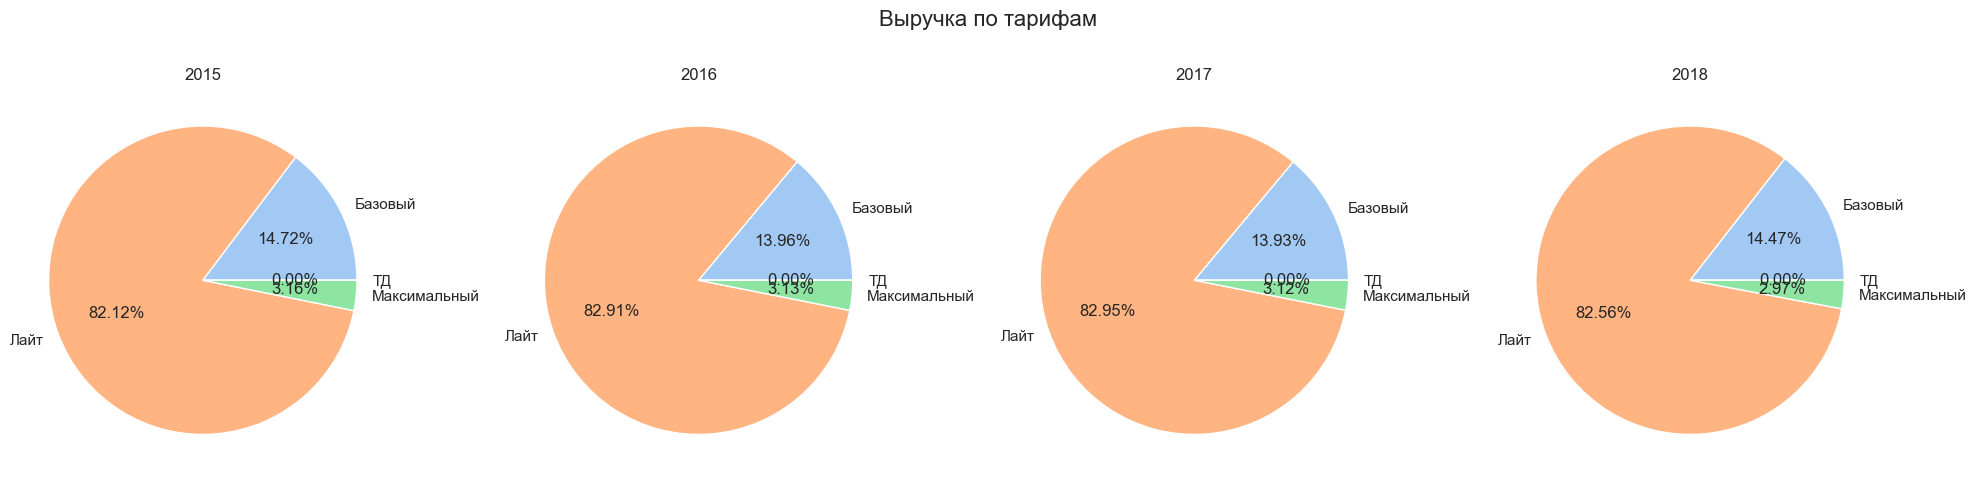

In [157]:
p = plans_grouped_by_plan.reset_index()

colors = sns.color_palette('pastel')

fig = plt.figure()
fig.suptitle("Выручка по тарифам\n", fontsize=16)
fig.set_size_inches(20,5)
for index, year in enumerate(p['year'].unique()):
    plt.subplot(1,4,index+1)
    pp = p[p['year'] == year]
    plt.pie(x = pp['Общая_выручка'], labels=pp['Тариф'],colors = colors, autopct='%.2f%%')
    plt.title(year)

plt.tight_layout()
plt.show()

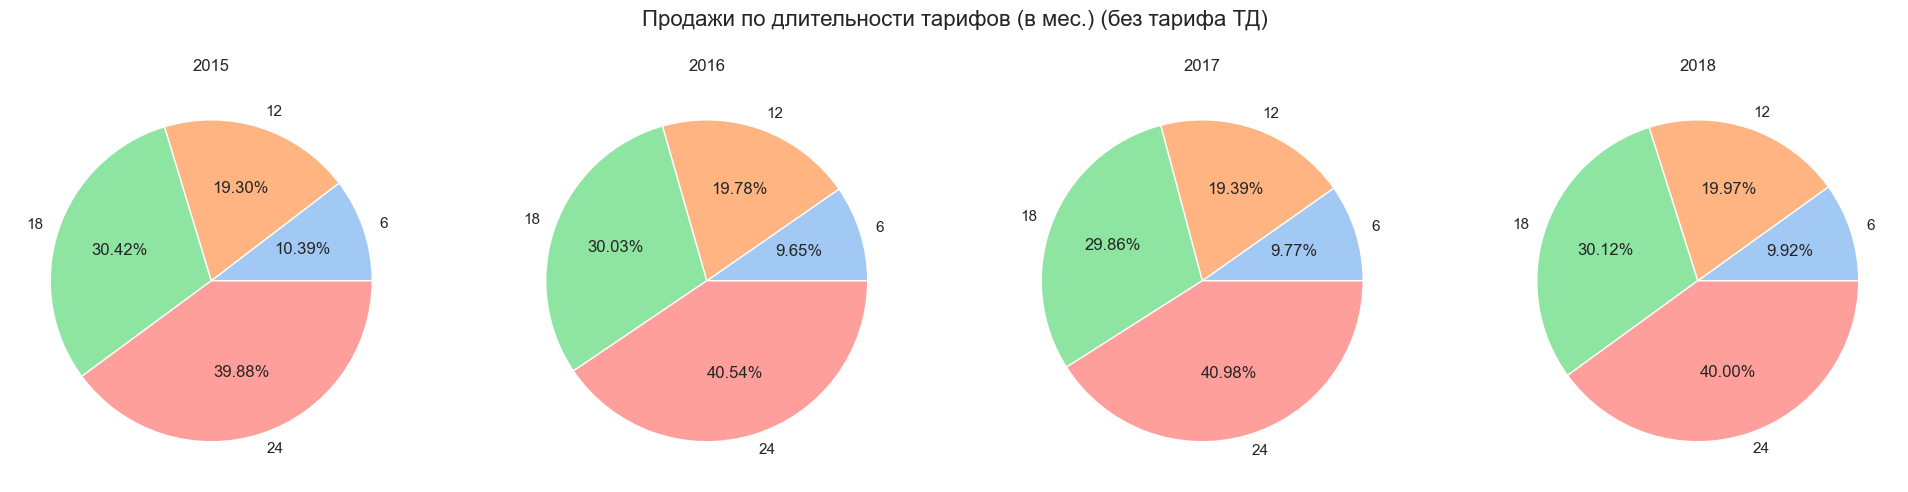

In [156]:
p = plans_grouped_by_dur.reset_index()
p.drop(p[p['Длительность'].astype(int)  <= 4].index,inplace=True)

colors = sns.color_palette('pastel')

fig = plt.figure()
fig.suptitle("Продажи по длительности тарифов (в мес.) (без тарифа ТД)\n", fontsize=16)
fig.set_size_inches(20,5)
for index, year in enumerate(p['year'].unique()):
    plt.subplot(1,4,index+1)
    pp = p[p['year'] == year]
    plt.pie(x = pp['Количество_продаж'], labels=pp['Длительность'],colors = colors, autopct='%.2f%%')
    plt.title(year)

plt.tight_layout()
plt.show()

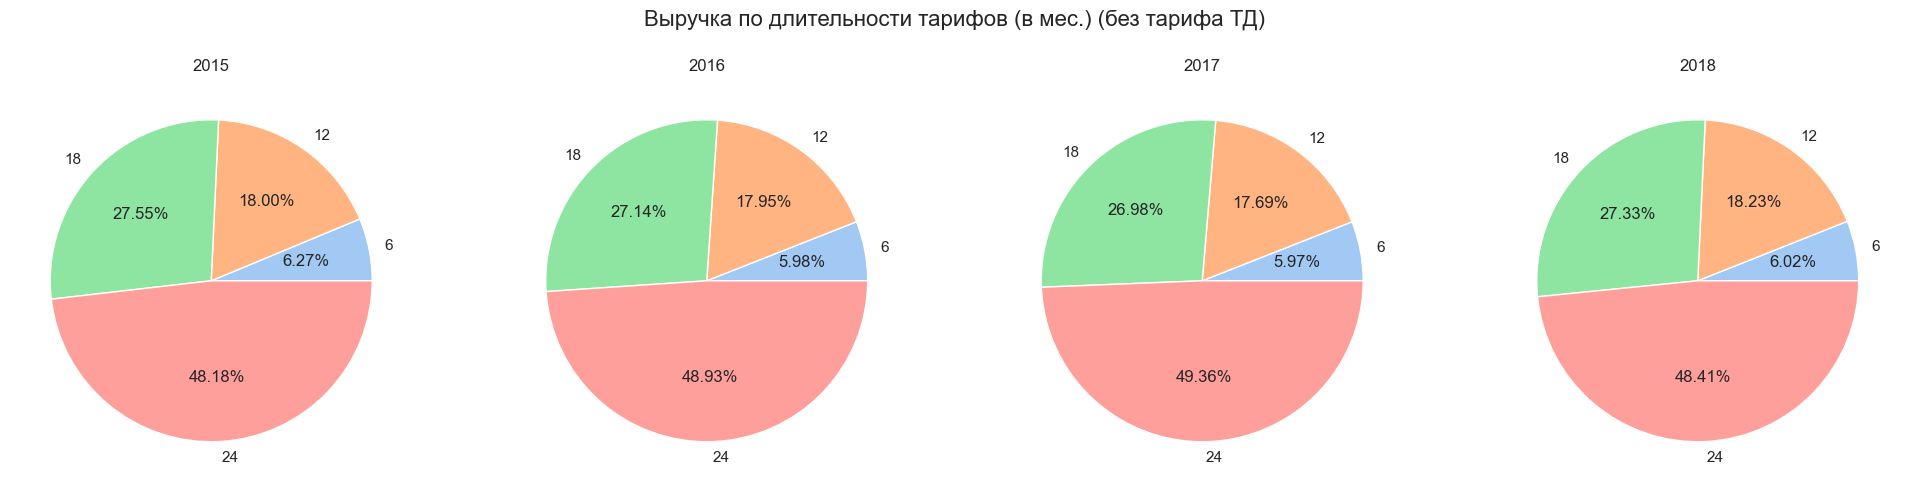

In [255]:
p = plans_grouped_by_dur.reset_index()
p.drop(p[p['Длительность'].astype(int)  <= 4].index,inplace=True)

colors = sns.color_palette('pastel')

fig = plt.figure()
fig.suptitle("Выручка по длительности тарифов (в мес.) (без тарифа ТД)\n", fontsize=16)
fig.set_size_inches(20,5)
for index, year in enumerate(p['year'].unique()):
    plt.subplot(1,4,index+1)
    pp = p[p['year'] == year]
    plt.pie(x = pp['Общая_выручка'], labels=pp['Длительность'],colors = colors, autopct='%.2f%%')
    plt.title(year)

plt.tight_layout()
plt.show()

In [41]:
pd.set_option('display.max_rows', 10)


clients = pd.read_sql('''
select BDate,strftime('%Y', BDate) as year, cID, piID, revenue, personal from Clients
join Bills using (cID)
join BillsContent using (bID)
join PriceItems using (piID)
join OrgStat using (ogrn)
where product = "Бухгалтерия.Контур"
order by BDate
''',conn)
clients

,BDate,year,cID,piID,revenue,personal
0,2015-06-01,2015,9360,15,50000.0,5.0
1,2015-06-01,2015,9360,15,3000.0,1.0
2,2015-06-01,2015,9360,15,3000.0,2.0
3,2015-06-01,2015,9360,15,18000.0,1.0
4,2015-06-01,2015,250804,136,604000.0,17.0
...,...,...,...,...,...,...
155844,2018-12-31,2018,328582,120,280000.0,34.0
155845,2018-12-31,2018,198073,120,218000.0,7.0
155846,2018-12-31,2018,198073,120,112000.0,5.0
155847,2018-12-31,2018,198073,120,123000.0,6.0


In [42]:
clients['Тариф'] = clients['piID'].apply(lambda x: id_to_plan(x))
clients['Длительность'] = clients['piID'].apply(lambda x: id_to_dur(x))
clients2 = clients.drop(columns=['piID'])
clients2

,BDate,year,cID,revenue,personal,Тариф,Длительность
0,2015-06-01,2015,9360,50000.0,5.0,Лайт,6
1,2015-06-01,2015,9360,3000.0,1.0,Лайт,6
2,2015-06-01,2015,9360,3000.0,2.0,Лайт,6
3,2015-06-01,2015,9360,18000.0,1.0,Лайт,6
4,2015-06-01,2015,250804,604000.0,17.0,Базовый,12
...,...,...,...,...,...,...,...
155844,2018-12-31,2018,328582,280000.0,34.0,Лайт,12
155845,2018-12-31,2018,198073,218000.0,7.0,Лайт,12
155846,2018-12-31,2018,198073,112000.0,5.0,Лайт,12
155847,2018-12-31,2018,198073,123000.0,6.0,Лайт,12


In [213]:
years = clients['year'].astype(int).unique()
years.sort()
ids = []
for year in years:
    ids.append(set(clients[clients['year'] == str(year)]['cID'].unique()))


client_base = ids[0]
new_old_clients = pd.DataFrame(columns=['year', 'new_clients', 'old_clients'],data=[[years[0], len(client_base),0]])
for idss,year in zip(ids[1:], years[1:]):
    new_clients = idss.difference(client_base)
    old_clients = idss.intersection(client_base)
    new_old_clients = pd.concat([new_old_clients, pd.DataFrame(columns=['year', 'new_clients', 'old_clients'],data=[[year, len(new_clients), len(old_clients)]])])
    client_base = client_base.union(idss)
new_old_clients

,year,new_clients,old_clients
0,2015,6304,0
0,2016,9546,2681
0,2017,6626,6129
0,2018,3151,7371


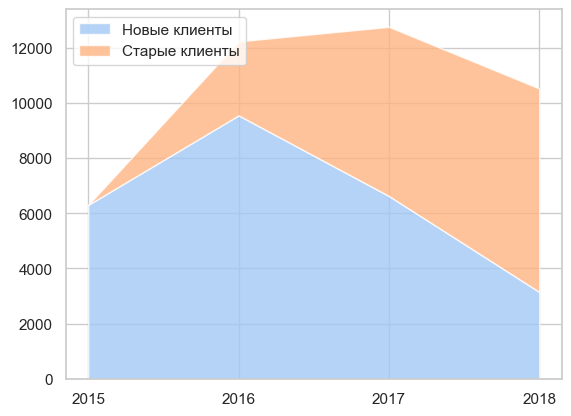

In [193]:
plt.stackplot(new_old_clients['year'].astype(str), new_old_clients['new_clients'],new_old_clients['old_clients'],labels=['Новые клиенты', 'Старые клиенты'],alpha=0.8)
plt.legend(loc='upper left')
plt.show()

In [226]:
clients_base = set()
clients2['is_new'] = True
for idx, row in clients2.iterrows():
    clients2.at[idx,'is_new'] = row['cID'] not in clients_base
    clients_base.add(row['cID'])

In [231]:
clients2

,BDate,year,cID,Тариф,Длительность,is_new
0,2015-06-01,2015,9360,Лайт,6,True
1,2015-06-01,2015,335977,Базовый,12,True
2,2015-06-01,2015,250804,Базовый,12,True
3,2015-06-01,2015,104506,Базовый,12,True
4,2015-06-01,2015,229986,Базовый,12,True
...,...,...,...,...,...,...
53977,2018-12-31,2018,15892,Лайт,24,False
53978,2018-12-31,2018,337492,Базовый,6,True
53979,2018-12-31,2018,409156,Лайт,12,True
53980,2018-12-31,2018,328582,Лайт,12,False


In [251]:
new_clients = clients2[clients2['is_new']]
new_by_plan = new_clients.groupby(['year','Тариф']).count().reset_index().drop(columns=['BDate','Длительность','is_new'])
new_by_plan

,year,Тариф,cID
0,2015,Базовый,864
1,2015,Лайт,5157
2,2015,Максимальный,213
3,2015,ТД,70
4,2016,Базовый,1240
...,...,...,...
11,2017,ТД,53
12,2018,Базовый,429
13,2018,Лайт,2599
14,2018,Максимальный,101


In [252]:
new_by_dur = new_clients.groupby(['year','Длительность']).count().reset_index().drop(columns=['BDate','Тариф','is_new'])
new_by_dur

,year,Длительность,cID
0,2015,1,32
1,2015,2,17
2,2015,3,10
3,2015,4,11
4,2015,6,643
...,...,...,...
27,2018,4,2
28,2018,6,293
29,2018,12,629
30,2018,18,960


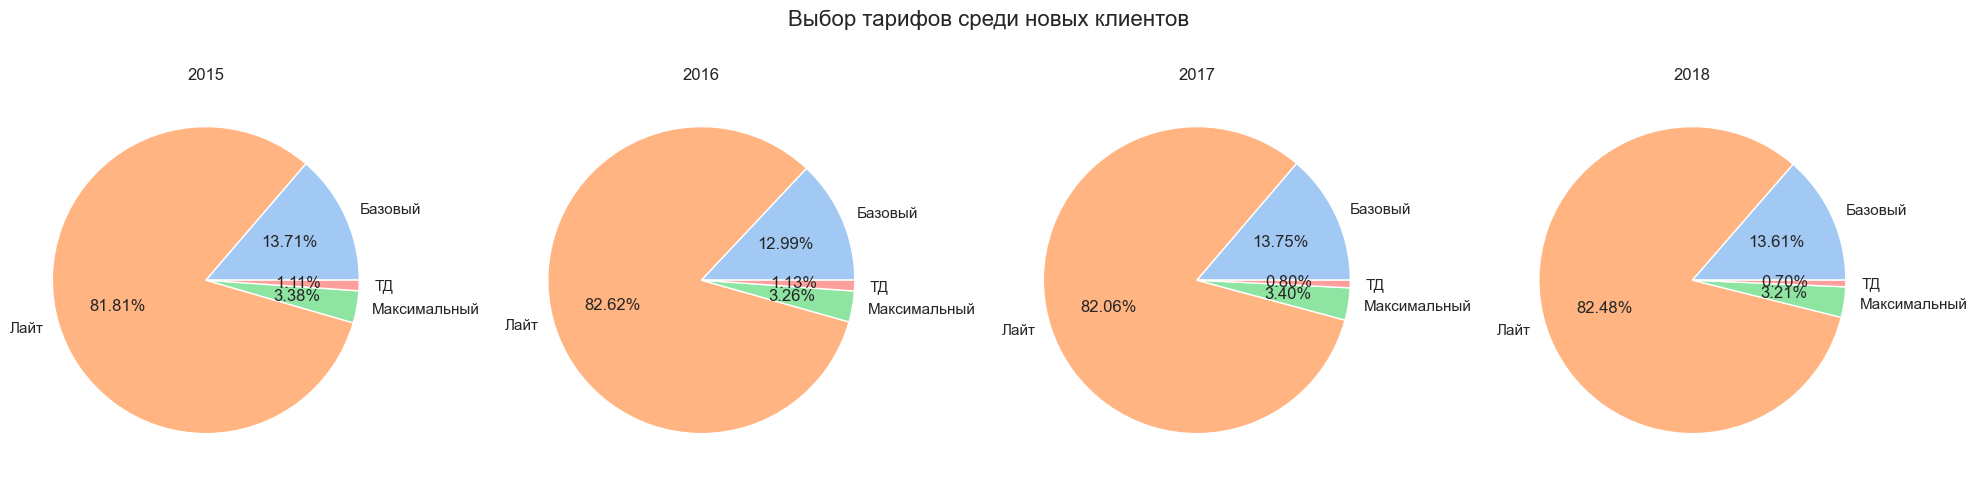

In [253]:
colors = sns.color_palette('pastel')

fig = plt.figure()
fig.suptitle("Выбор тарифов среди новых клиентов\n", fontsize=16)
fig.set_size_inches(20,5)
for index, year in enumerate(new_by_plan['year'].unique()):
    plt.subplot(1,4,index+1)
    pp = new_by_plan[new_by_plan['year'] == year]
    plt.pie(x = pp['cID'], labels=pp['Тариф'],colors = colors, autopct='%.2f%%')
    plt.title(year)

plt.tight_layout()
plt.show()

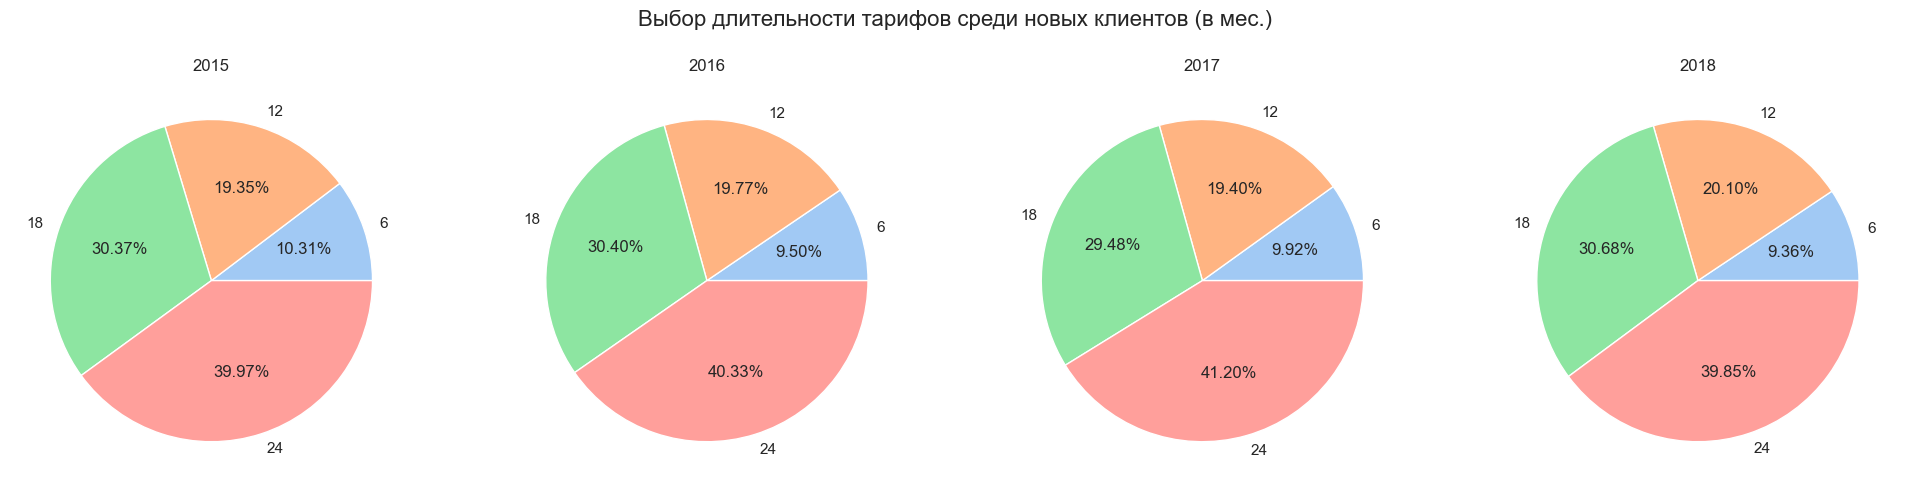

In [254]:
colors = sns.color_palette('pastel')

fig = plt.figure()
fig.suptitle("Выбор длительности тарифов среди новых клиентов (в мес.)\n", fontsize=16)
fig.set_size_inches(20,5)
new_by_dur.drop(new_by_dur[new_by_dur['Длительность'].astype(int)  <= 4].index,inplace=True)
for index, year in enumerate(new_by_dur['year'].unique()):
    plt.subplot(1,4,index+1)
    pp = new_by_dur[new_by_dur['year'] == year]
    plt.pie(x = pp['cID'], labels=pp['Длительность'],colors = colors, autopct='%.2f%%')
    plt.title(year)

plt.tight_layout()
plt.show()

In [11]:
all_products_sales = pd.read_sql('''
select product, strftime('%Y', BDate) as year, count(*) as sales 
from BillsContent
join PriceItems using (piID)
join Bills using (bID)
group by product, year
''',conn)
all_products_sales

,product,year,sales
0,Бухгалтерия.Контур,2015,8117
1,Бухгалтерия.Контур,2016,16554
2,Бухгалтерия.Контур,2017,16488
3,Бухгалтерия.Контур,2018,12823
4,Диадок,2016,61833
5,Диадок,2017,84554
6,Диадок,2018,64948
7,КЭП,2018,42375
8,КЭП.Универсальный,2015,177465
9,КЭП.Универсальный,2016,96384


Text(0.5, 1.0, 'Продажи по всем продуктам')

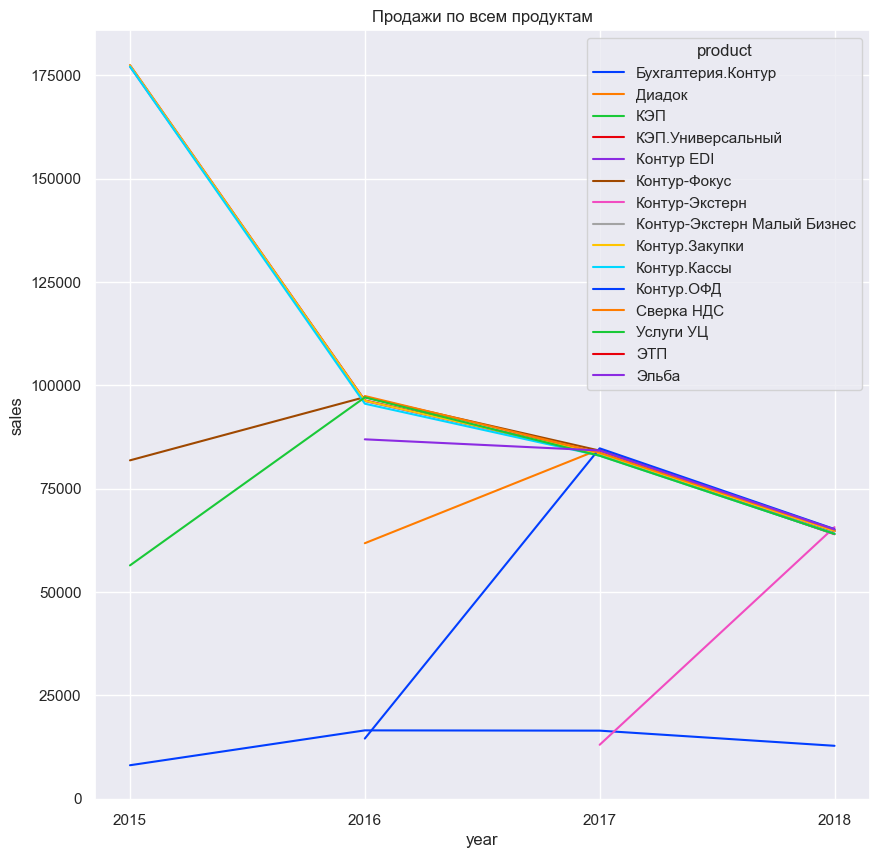

In [17]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.lineplot(data=all_products_sales, x='year',y='sales', hue='product',palette='bright')
plt.title('Продажи по всем продуктам')

Text(0.5, 1.0, 'Оборот клиентов по тарифам')

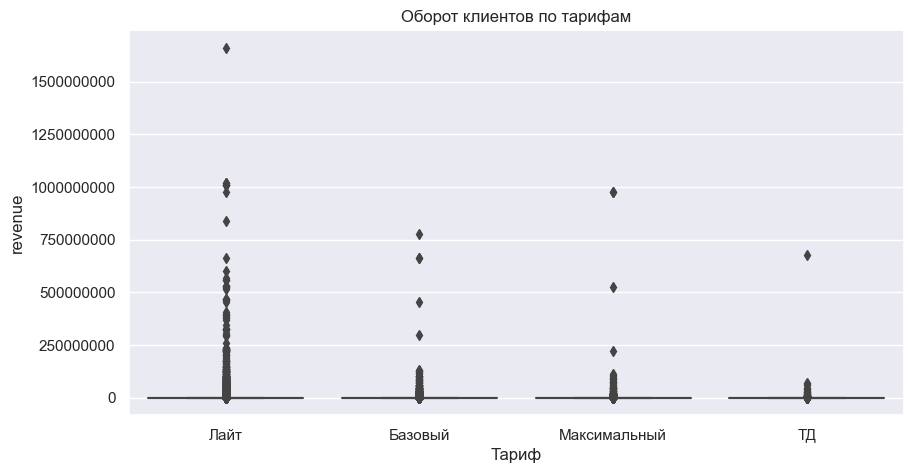

In [47]:
plt.figure(figsize=(10,5))
sns.boxplot(data=clients.drop(clients['revenue'].idxmax()),x='Тариф',y='revenue')
plt.ticklabel_format(axis='y',style='plain')
plt.title('Оборот клиентов по тарифам')

Text(0.5, 1.0, 'Оборот клиентов по тарифам')

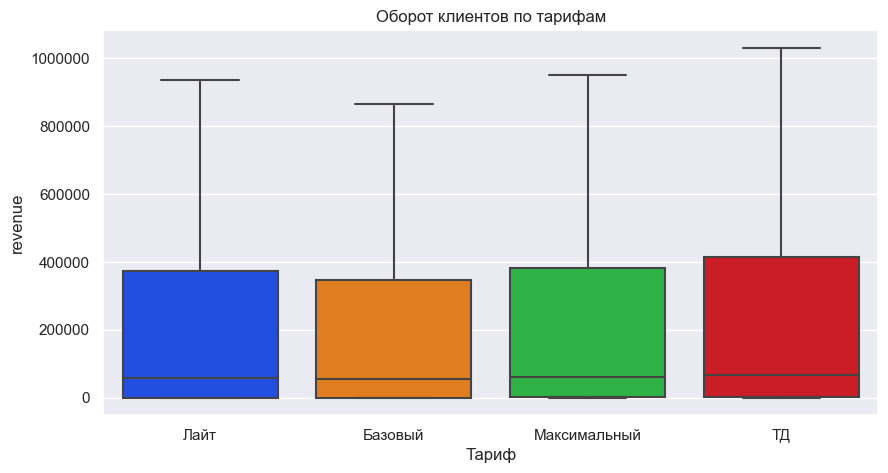

In [40]:
plt.figure(figsize=(10,5))
sns.boxplot(data=clients,x='Тариф',y='revenue',showfliers=False)
plt.ticklabel_format(axis='y',style='plain')
plt.title('Оборот клиентов по тарифам')

Text(0.5, 1.0, 'Оборот клиентов по тарифам')

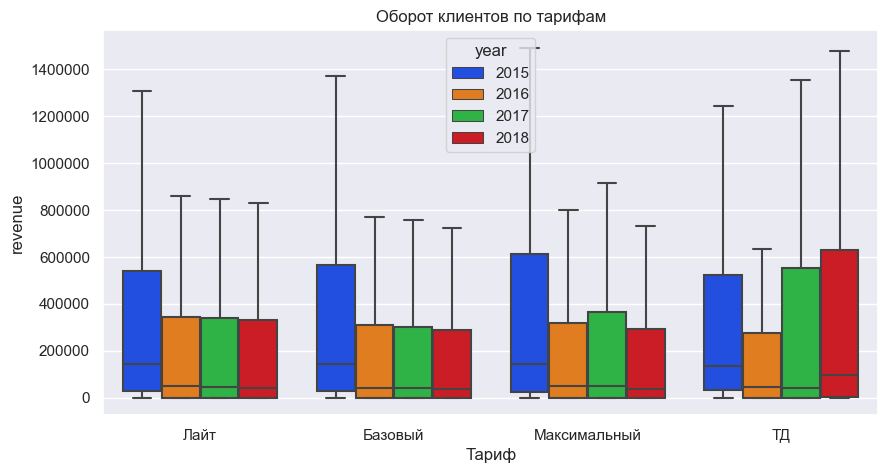

In [38]:
plt.figure(figsize=(10,5))
sns.boxplot(data=clients,x='Тариф',y='revenue',hue='year',showfliers=False)
plt.ticklabel_format(axis='y',style='plain')
plt.title('Оборот клиентов по тарифам')

Text(0.5, 1.0, 'Персонал клиентов по тарифам')

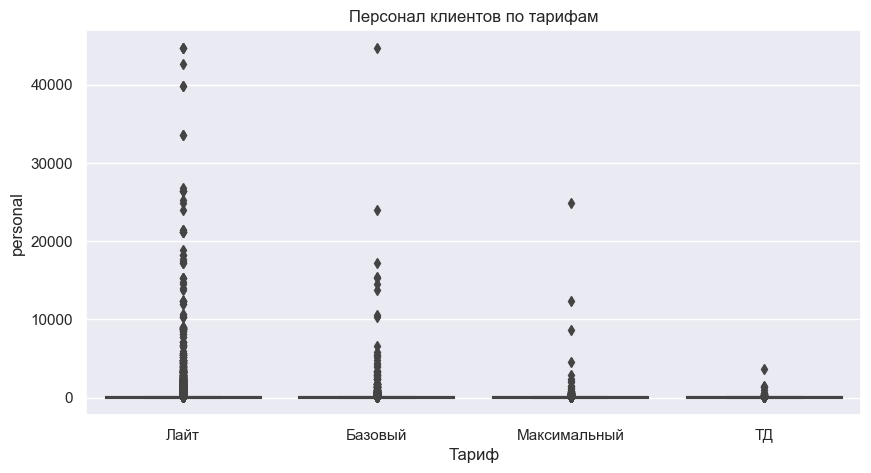

In [45]:
plt.figure(figsize=(10,5))
sns.boxplot(data=clients,x='Тариф',y='personal')
plt.ticklabel_format(axis='y',style='plain')
plt.title('Персонал клиентов по тарифам')

Text(0.5, 1.0, 'Персонал клиентов по тарифам')

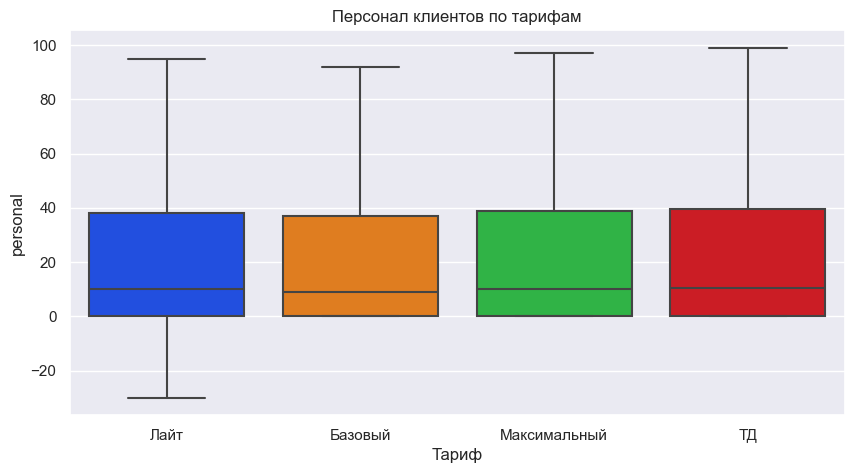

In [48]:
plt.figure(figsize=(10,5))
sns.boxplot(data=clients,x='Тариф',y='personal',showfliers=False)
plt.ticklabel_format(axis='y',style='plain')
plt.title('Персонал клиентов по тарифам')

## Анализ

По графику план-факта продаж и выручки видно, что в годовых разрезах план за 2015-2018 года выполняется и даже перевыполняется. В помесячном же разрезе, в некоторые месяцы план немного недовыполнен, однако таких месяцев мало.

Из динамики продаж и выручки по продукту "Бухгалтерия.Контур" выдно, что продажи в 2018 году пошли на спад в сравнении с предыдущими годами, в которые они показывали рост. Посмотрев на динамику экономики РФ в Википедии, видно, что в 2015-2018 годах показатели ВВП росли, а темпы роста увеличивались. Из основных экономических потрясений в стране за 2018 год можно выделить пенсионную реформу, повышение НДС до 20%, санкции и повышение цен на бензин. Эти критерии не имеют прямого влияния на продукты Контура, кроме разве что санкций. Однако, они были направлены в основном на госкредиты, некоторый экспорт и военно-промышленный комплекс, что не должно было особо сказаться на целевой аудитории продукта. Теория о переходе клиентов с Бухгалтерии.Контур на другие аналогичные продукты Контура неверна, так как спад продаж заметен по всем продуктам компании кроме Экстерна, которая не заменяет бухгалтерские продукты. Можно, сделать вывод, что спад продаж и соответственно выручки в 2018 году был системным по всей продукции контура в том числе и анализируемой "Контур.Бухгалтерии", причинами которой вероятнее всего являются внутренние бизнес-решения компании, чем внешнеэкономические факторы. Смотря на план продаж, можно сделать вывод, что уменьшение продаж в 2018 году было спрогнозировано заранее и об этом было известно руководству.

У Контур.Бухгалтерии есть 4 группы тарифов (Лайт, базовый, максимальный, ТД). ТД является бесплатным тарифом (возможно, промо или пробный тариф), но на него выпадает ~1% продаж. Так что, сконцентрируемся на других трёх тарифах. Продукт можно купить на 6, 12, 18 или 24 месяца.
Самым популярным тарифом по продажам и выручке является Лайт (~82% продаж). Далее, Базовый с ~13% и оставшиеся 3-4% занимает максимальный тариф. Рассматривая продажи по длительности доступа к продукту лидирует самый длинный срок (2 года). Далее процент продаж выстроился по убыванию длительности срока. Можно сделать вывод, что ценовая политика построена грамотно и клиенты склонны выбирать более долгое сотрудничество с компанией и использование продукта. 

В графике продаж и выручки по тарифам и сроку доступа к продукту во всех категориях статистики двигаются в соответствии с глобальным трендом: увеличение в 2015-2017 и спад в 2018 годах. Структура продаж и выручки по срезам при этом из года в год сохраняется с преобладанием тарифа Лайт и выбором более длительных сроков.

Проанализировав клиентскую базу Бухгалтерии.Контур видно, что количество новых клиентов уменьшается, а рост старых клиентов, продолжающих использовать продукт уменьшается, что при сохранении такой тенденции может привести к уменьшению выручки или даже убыточности продукта.

Структура выбора тарифов и длительности тарифов среди новых клиентов (первой покупки) соответствует глобальной структуре по всем продажам и так же не меняется с течением лет.

На последних графиках, показывающих оборот и количество персонала среди клиентов Контур.Бухгалтерии агрегированных по тарифам видно, что основная аудитория продукта это микро и малый бизнес, что соответсвует целевой аудитории. Однако, средний и крупный бизнес тоже использует продукт, но в гораздо меньших масштабах. Также, видно, что выбор тарифа не зависит от размера компании и ее экономических показателей.

## Предложения по целям на будущее время
- Стимулировать покупку более продвинутых и соответственно дорогих тарифных планов, чтобы сместиться с многократного преоблодания тарифа "Лайт". (Пересмотр цен более продвинутых тарифов, стимулировать желание клиентов воспольоваться фичами более дорогих тарифов)
- Поддерживать клиентов оставаться с Контуром на более долгий срок и продлевать подписку на продукт. (Скидки за продолжение сотрудничества, добавление нового функционала, добавление функционала, присутствующего у конкурентов, привязка клиентов к инфраструктуре Контура)
- Увеличить количество новой аудитории продукта. (Реклама, специальные и промо-предложения, пробные тарифы, разработка нового привлекающего функционала).
- Вернуться по показателям продаж до уровня 2017 года.

# Прогноз



## Логика и последовательность выполнения'

Сначала я использовал ARIMA модель. Однако, ее было сложно затюнить на реальные данные и метрики были плохими. После этого, я решил попробовать autoARIMA, которая по сути является grid search-ем над ARIMA. Мне всё равно не понравился результат выдающийся данным методом, и для решения здачи прогнозирования я использовал библиотеку prophet от Meta. 

In [1]:
from datetime import datetime
import numpy as np             
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
data = pd.read_sql('''
select strftime('%Y', BDate) as year, strftime('%m', BDate) as month, count(*) as count from BillsContent
join Bills using(bID)
join PriceItems using (piID)
where product = 'Бухгалтерия.Контур'
group by year, month
''',conn)

In [5]:
df = data.copy()
df['date'] = df.apply(lambda row: datetime(int(row['year']),int(row['month']),1),axis=1)
df.drop(columns=['year','month',],inplace=True)
df.set_index('date',inplace=True,drop=True)
df.head()

,count
date,
2015-06-01,1282
2015-07-01,1263
2015-08-01,1109
2015-09-01,1063
2015-10-01,1130


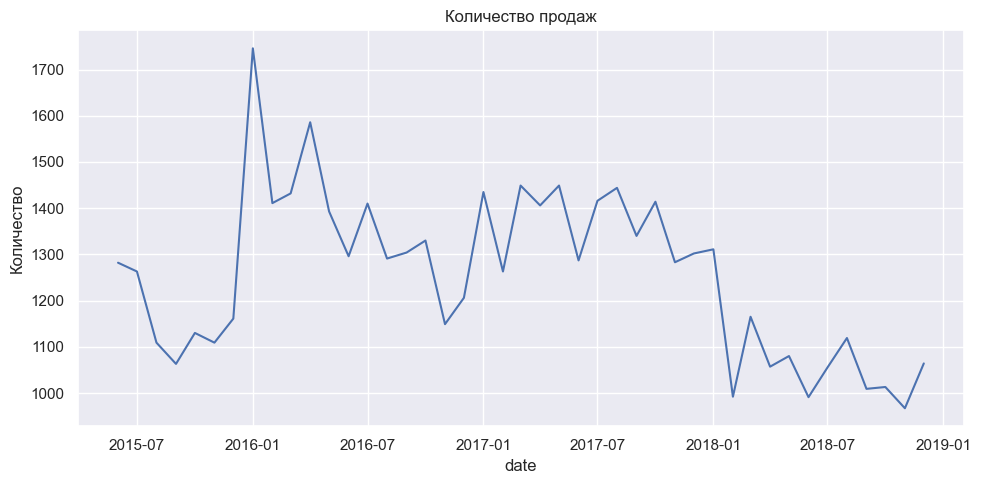

In [62]:
sns.set_theme()
plt.figure(figsize=(10,5))
sns.lineplot(df['count'])
plt.title('Количество продаж')
plt.ylabel("Количество")
plt.tight_layout()
plt.show()


In [6]:
prophet_df = df.reset_index().rename(columns={'date':'ds','count':'y'})
prophet_df

,ds,y
0,2015-06-01,1282
1,2015-07-01,1263
2,2015-08-01,1109
3,2015-09-01,1063
4,2015-10-01,1130
5,2015-11-01,1109
6,2015-12-01,1161
7,2016-01-01,1746
8,2016-02-01,1411
9,2016-03-01,1432


In [7]:
from prophet import Prophet

model = Prophet(interval_width=0.95)

model.fit(prophet_df)

17:34:12 - cmdstanpy - INFO - Chain [1] start processing
17:34:12 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
from dateutil.relativedelta import relativedelta


last_date = df.index[-1]
date_list = [last_date +  relativedelta(months=x) for x in range(1,13)]
future = pd.DataFrame(data={'ds':date_list})


In [9]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,1289.560430,1135.411817,1442.170567
1,2019-02-01,974.028878,817.680429,1134.286452
2,2019-03-01,900.972462,730.965427,1066.454738
3,2019-04-01,781.026869,621.853053,954.194553
4,2019-05-01,1069.440846,910.138927,1230.483180
5,2019-06-01,971.737711,811.849952,1133.239056
6,2019-07-01,960.421652,791.490320,1127.785429
7,2019-08-01,873.132644,708.498753,1036.549375
8,2019-09-01,746.164004,571.925047,916.408780
9,2019-10-01,752.870677,593.597379,914.793779


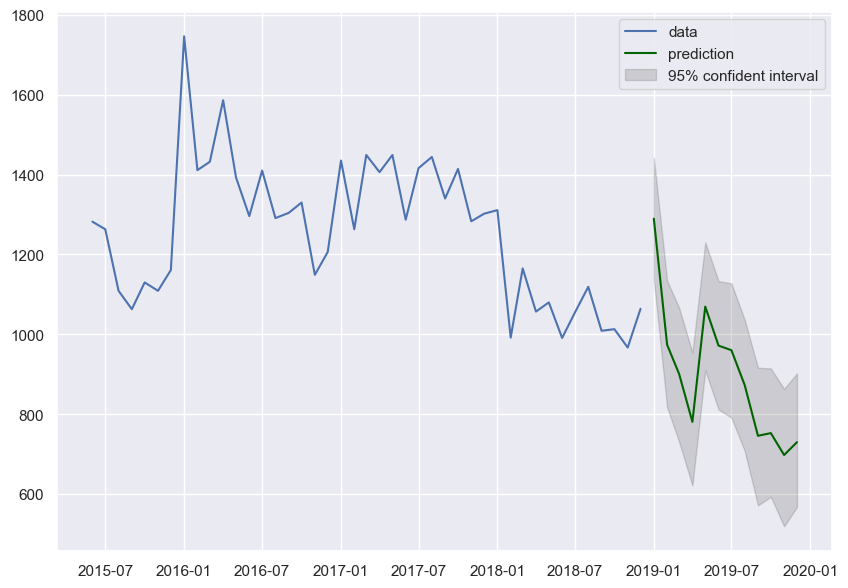

In [10]:
sns.set_theme()
plt.figure(figsize=(10,7))
plt.plot(prophet_df['ds'],prophet_df['y'],label='data')
plt.plot(forecast['ds'],forecast['yhat'], color='darkgreen',label='prediction')
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='k', alpha=.15,label='95% confident interval')

plt.legend()
plt.show()

## Выводы

По пронозу prophet, Контур.Бухгалтерию ждёт последующий спад продаж при сохранении текущей политики (маркетинговой, ценовой...) компании. Однако, как и в прошлые годы, будет рост продаж в начале года и в мае.

# Анализ рынка

## Логика и последовательность действий

На сайте росреестра ФНС я нашел статистику по количеству зврегистрированных ИП (https://ofd.nalog.ru/statistics.html). там же нашел статистики за 2017 2018 год по УСН, откуда вытащил количество ИП на УСН. Получилось что примерно 48% ИП работают на УСН. Из этого сделал приблищительный прогноз по количеству целевой аудитории, то есть ёмкость рынка.

In [52]:
import pandas as pd

df = pd.read_csv('usn17.csv',sep=';')

ids = ['G27','G29']

df.dropna(inplace=True)
df['G27'] = [int(str(val).replace(' ','')) for val in df['G27'].values]
df['G29'] = [int(str(val).replace(' ','')) for val in df['G29'].values]

# df['G33'] = df['G33'].astype(int)
# df['G35'] = df['G35'].astype(int)

# df[ids]
print("количество ИП на УСН в 2017")
print(df[ids].sum().sum())

df = pd.read_csv('usn18.csv',sep=';')

ids = ['G27','G29']

df.dropna(inplace=True)
df['G27'] = [int(str(val).replace(' ','')) for val in df['G27'].values]
df['G29'] = [int(str(val).replace(' ','')) for val in df['G29'].values]

# df['G33'] = df['G33'].astype(int)
# df['G35'] = df['G35'].astype(int)

# df[ids]
print("количество ИП на УСН в 2018")
print(df[ids].sum().sum())

количество ИП на УСН в 2017
1423030
количество ИП на УСН в 2018
1584397


In [55]:
ip_data = pd.DataFrame(data=[[2017,2937049,1423030],[2018,3287698,1584397]],columns=['Год','Кол-во ИП','кол-во ИП на УСН'])
ip_data['Процент'] = ip_data['кол-во ИП на УСН'] / ip_data['Кол-во ИП']
ip_data

,Год,Кол-во ИП,кол-во ИП на УСН,Процент
0,2017,2937049,1423030,0.484510
1,2018,3287698,1584397,0.481917


In [56]:
ip_df = pd.DataFrame(data=[[2016,3048986],[2017,3221706],[2018, 3325807]],columns=['Год','Количество'])
ip_df

,Год,Количество
0,2016,3048986
1,2017,3221706
2,2018,3325807


<Axes: xlabel='Год', ylabel='Количество'>

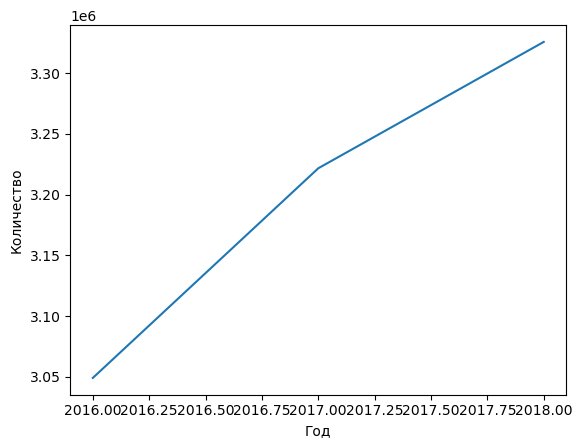

In [60]:
import seaborn as sns

sns.lineplot(data=ip_df,x='Год',y='Количество')

In [66]:
import numpy as np
print("Средний рост количества ИП в год")
np.mean(ip_df['Количество'].diff(1))

Средний рост количества ИП в год


138410.5

In [69]:
print("Примерное количество ИП в 2019", np.mean(ip_df['Количество'].diff(1)) + ip_df['Количество'].iloc[-1])

Примерное количество ИП в 2019 3464217.5


In [72]:
ip_df_pr = pd.DataFrame(data=[[2016,3048986],[2017,3221706],[2018, 3325807],[2019,3464217]],columns=['Год','Количество'])
ip_df_pr['ИП на УСН'] = ip_df_pr['Количество'] * 0.48
ip_df_pr

,Год,Количество,ИП на УСН
0,2016,3048986,1463513.28
1,2017,3221706,1546418.88
2,2018,3325807,1596387.36
3,2019,3464217,1662824.16


## Доля рынка

В интернете я нашел сайты со списком аналогов Контур.Бухгалтерии. Однако, я не смог найти дыннх по ним, чтобы посчитать долю рынка. Теоретически, при наличии количества продаж конкурентов, посчитать долю рынка было бы легко. При наличии данных о выручке по конкурирующим продуктам можно было бы аппроксимировать значение количества продаж этих продуктов, так как по условию средняя цена одинакова с таковой же у конкурентов.

## Вывод

По прогнозам видно, что нужно поднимать продажи продукта, меняя стратегии развития и маркетинга, улучшая продукт. Учитывая, что количество ИП увеличивается, нужно привелекать вновь созданные компании к работе с контуром.